In [15]:
import numpy as np
import utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import pickle
utils.reload(utils)

In [16]:
train_images = np.load('quickdraw_subset_np/train_images.npy').astype(np.float32)
train_labels = np.load('quickdraw_subset_np/train_labels.npy').astype(np.int32)
test_images = np.load('quickdraw_subset_np/test_images.npy').astype(np.float32)
test_labels = np.load('quickdraw_subset_np/test_labels.npy').astype(np.int32)

print(train_images.shape) # (20000, 28, 28)
print(test_images.shape) # (5000, 28, 28)

(20000, 28, 28)
(5000, 28, 28)


In [17]:
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

val_images = train_images[:2000]
val_labels = train_labels[:2000]
train_images = train_images[2000:]
train_labels = train_labels[2000:]

print(train_images.shape) # (20000, 784)
print(test_images.shape) # (5000, 784)

(18000, 784)
(5000, 784)


In [18]:
print(np.unique(val_labels, return_counts=True))
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array([0, 1, 2, 3, 4], dtype=int32), array([397, 379, 398, 410, 416]))
(array([0, 1, 2, 3, 4], dtype=int32), array([3603, 3621, 3602, 3590, 3584]))
(array([0, 1, 2, 3, 4], dtype=int32), array([1000, 1000, 1000, 1000, 1000]))


In [19]:
train_loader= utils.DataLoader(train_images, train_labels, batch_size=64, shuffle=True)
validation_loader = utils.DataLoader(val_images, val_labels, batch_size=64, shuffle=False)
test_loader = utils.DataLoader(test_images, test_labels, batch_size=64, shuffle=False)

In [20]:
class MLP(utils.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = utils.Linear(input_size, hidden_size)
        self.relu1 = utils.ReLU()
        self.fc2 = utils.Linear(hidden_size, hidden_size)
        self.relu2 = utils.ReLU()
        self.fc3 = utils.Linear(hidden_size, output_size)
        self.softmax = utils.Softmax()
        self.construct()
    
    def construct(self):
        self.cache.append(self.fc1)
        self.cache.append(self.relu1)
        self.cache.append(self.fc2)
        self.cache.append(self.relu2)
        self.cache.append(self.fc3)
        self.cache.append(self.softmax)

    def load_weights(self, weights):
        self.fc1.load_weights(weights[0], weights[1])
        self.fc2.load_weights(weights[2], weights[3])
        self.fc3.load_weights(weights[4], weights[5])

    def save_weights(self):
        weights = []
        weights.append(self.fc1.weight)
        weights.append(self.fc1.bias)
        weights.append(self.fc2.weight)
        weights.append(self.fc2.bias)
        weights.append(self.fc3.weight)
        weights.append(self.fc3.bias)
        return weights
    
    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.save_weights(), f)

    def save_model_from_weights(self, weights, filename):
        with open(filename, 'wb') as f:
            pickle.dump(weights, f)
        print("Model saved successfully.")
        return weights

    def load_model(self, filename):
        with open(filename, 'rb') as f:
            weights = pickle.load(f)
        self.load_weights(weights)
        print("Model loaded successfully.")
        return weights
    
    def __str__(self):
        out = "MLP(\n"
        layer_idx = 1
        for layer in self.cache:
            if type(layer) == utils.Linear:
                out += f"  (fc{layer_idx}): {layer}\n"
                layer_idx += 1
            elif type(layer) == utils.ReLU:
                out += f"  (relu): {layer}\n"
            elif type(layer) == utils.Softmax:
                out += f"  (softmax): {layer}\n"
        out += ")"
        return out


In [21]:
model = MLP(784, 128, 5)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (softmax): Softmax()
)


In [22]:
criterion = utils.CrossEntropyLoss()
optimizer = utils.SGD(model, lr=0.001, momentum=0.9)

In [23]:
def train(model, train_loader, validation_loader, criterion, optimizer, num_epochs=10, save_best=True):
    train_losses = []
    val_losses = []
    train_size = len(train_loader)
    val_size = len(validation_loader)
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model_weights = None
    best_epoch = 0
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            criterion.backward()
            optimizer.step(criterion)
            running_loss += loss
            preds = np.argmax(outputs, axis=1)
            running_corrects += np.sum(preds == labels)
        train_losses.append(running_loss/(i+1))
        train_accuracies.append(running_corrects/train_size)
        
        val_running_loss = 0.0
        val_running_corrects = 0
        for i, data in enumerate(validation_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss
            preds = np.argmax(outputs, axis=1)
            val_running_corrects += np.sum(preds == labels)
        val_losses.append(val_running_loss/(i+1))
        val_accuracies.append(val_running_corrects/val_size)

        if save_best and val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_weights = model.save_weights()
            best_epoch = epoch

        tqdm.write(f'Epoch {epoch+1}, Loss: {train_losses[-1]}, Accuracy: {train_accuracies[-1]}')
        tqdm.write(f'Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}')

    if save_best:
        model.save_model_from_weights(best_model_weights, 'best_custom_model.pkl')
        print(f"Best model saved at epoch {best_epoch+1} with validation loss: {best_val_loss} and accuracy: {val_accuracies[best_epoch]}")

    model.save_model('final_custom_model.pkl')
    print("Final model saved successfully.")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [24]:
history = train(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 1.5939170459239143, Accuracy: 0.29394444444444445
Validation Loss: 1.479288760368945, Validation Accuracy: 0.4185
Epoch 2, Loss: 1.4013861776015835, Accuracy: 0.4747222222222222
Validation Loss: 1.332079842191888, Validation Accuracy: 0.5355
Epoch 3, Loss: 1.261636523300359, Accuracy: 0.5674444444444444
Validation Loss: 1.202574861861649, Validation Accuracy: 0.591
Epoch 4, Loss: 1.1421323609538376, Accuracy: 0.6153888888888889
Validation Loss: 1.097251814622723, Validation Accuracy: 0.619
Epoch 5, Loss: 1.0480467081854306, Accuracy: 0.6436111111111111
Validation Loss: 1.018249043961987, Validation Accuracy: 0.6385
Epoch 6, Loss: 0.9771931062661795, Accuracy: 0.6665555555555556
Validation Loss: 0.9588245434679266, Validation Accuracy: 0.6555
Epoch 7, Loss: 0.9238851873600626, Accuracy: 0.6798888888888889
Validation Loss: 0.9150708430333907, Validation Accuracy: 0.664
Epoch 8, Loss: 0.8844948123804259, Accuracy: 0.6906111111111111
Validation Loss: 0.8828758833697066, Vali

In [25]:
model.load_model('best_custom_model.pkl')

Model loaded successfully.


[array([[ 0.04586045,  0.03767272,  0.01034016, ..., -0.05343081,
         -0.0075743 ,  0.04866399],
        [ 0.01395127, -0.02023657,  0.08465694, ..., -0.00343332,
         -0.04581393, -0.05618566],
        [-0.03773474,  0.00113611,  0.00576791, ..., -0.07459766,
          0.07721485,  0.04799196],
        ...,
        [-0.03574364, -0.03181888, -0.05485   , ...,  0.03073479,
         -0.02608091,  0.02597713],
        [-0.07159523, -0.02816599,  0.06207843, ..., -0.01085939,
          0.00280162,  0.05219082],
        [-0.00540833, -0.07507251, -0.14248765, ...,  0.08583024,
         -0.07883165,  0.05798573]], dtype=float32),
 array([[-5.17485589e-02],
        [ 4.81621958e-02],
        [ 1.94584616e-02],
        [ 4.44386825e-02],
        [ 4.39050235e-02],
        [ 3.39322314e-02],
        [ 1.62501503e-02],
        [ 4.19234345e-03],
        [ 1.39139835e-02],
        [ 1.84528977e-02],
        [-1.91178836e-03],
        [ 1.93169471e-02],
        [ 1.34296031e-04],
       

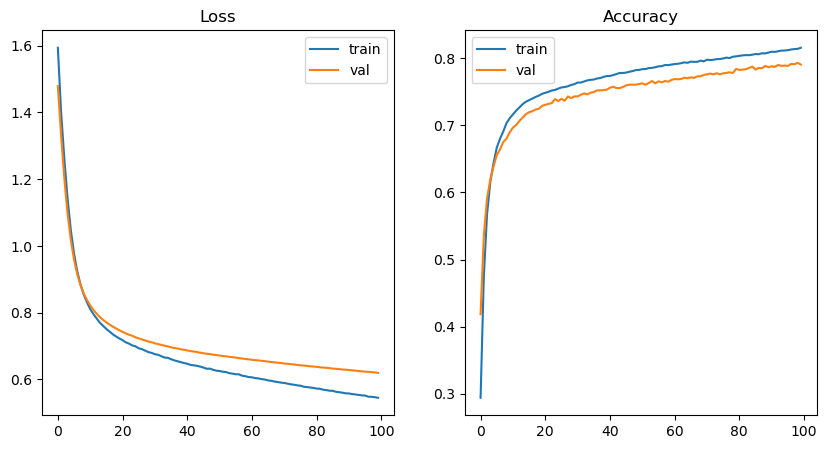

In [26]:
# Plot history graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history[0], label='train')
plt.plot(history[1], label='val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history[2], label='train')
plt.plot(history[3], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()


In [27]:
def test(model, test_loader):
    all_preds = []
    all_labels = []
    all_probs = []
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        preds = np.argmax(outputs, 1)
        all_preds.extend(preds)
        all_labels.extend(labels)
        all_probs.extend(outputs)
    return all_preds, all_labels, all_probs

all_preds, all_labels, all_probs = test(model, test_loader)

Accuracy: 0.7954
Precision: 0.7950077078465068
Recall: 0.7954000000000001
F1: 0.7946503783121148
[[761 106  35  46  52]
 [ 95 650  62  54 139]
 [ 37  45 869  12  37]
 [ 53  73  28 839   7]
 [ 39  75  28   0 858]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1000
           1       0.68      0.65      0.67      1000
           2       0.85      0.87      0.86      1000
           3       0.88      0.84      0.86      1000
           4       0.78      0.86      0.82      1000

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.79      5000
weighted avg       0.80      0.80      0.79      5000



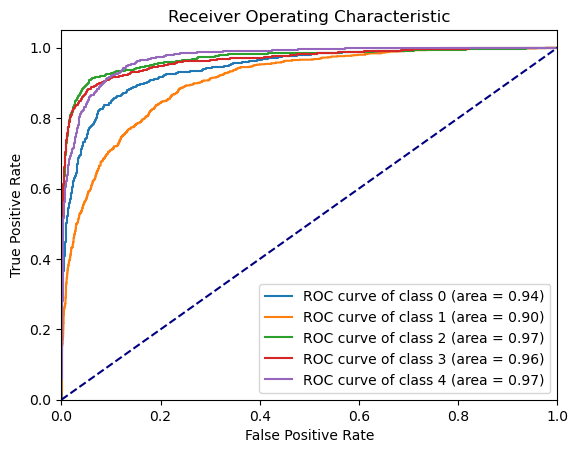

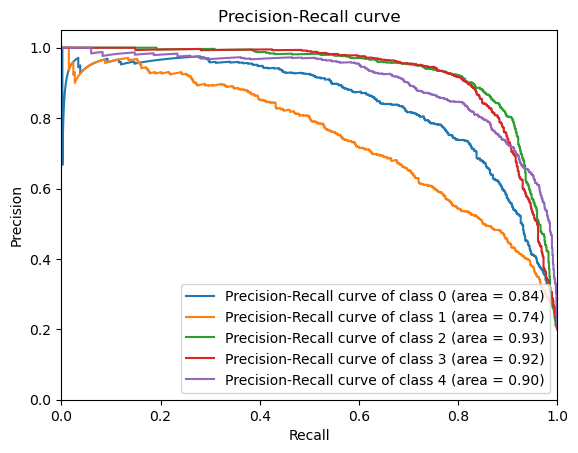

In [28]:
print('Accuracy:', accuracy_score(all_labels, all_preds))
print('Precision:', precision_score(all_labels, all_preds, average='macro'))
print('Recall:', recall_score(all_labels, all_preds, average='macro'))
print('F1:', f1_score(all_labels, all_preds, average='macro'))

cm = confusion_matrix(all_labels, all_preds)
print(cm)

print(classification_report(all_labels, all_preds))


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
n_classes = 5
all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# ROC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
    average_precision[i] = average_precision_score(all_labels_bin[:, i], all_probs[:, i])

plt.figure()

for i in range(5):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower right')
plt.show()